### Week 3 exercises

please execute the cell below to get started!

In [2]:
!pip install brian2
!pip install neurodynex3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 9.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 75 kB 2.8 MB/s 
     |████████████████████████████████| 1.6 MB 15.7 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 154 kB 54.6 MB/s 
  Created wheel for brian2: filename=Brian2-2.3-cp37-cp37m-linux_x86_64.whl size=1283978 sha256=61e5a59e4490c9e0f9a034b7b21ba8c97c2e3413958aff50de378afd8cd05714
  Stored in directory: /root/.cache/pip/wheels/59/ac/59/705b1babcd0bee25cc7e56c5616ed85dbd7afab2942e8b18cd
Successfully built brian2
  Attempting uninstall: brian2
    Found existing installation: Brian2 2.5.1
    Uninstalling Brian2-2.5.1:
      Successfully uninstalled Brian2-2.5.1


In [3]:
%matplotlib inline  
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

### Hodgkin-Huxley neurons in vertebrates
Here, the HH simulation that we used in week 2 has been modified to reflect the parameters found in verterbrates (rather than the squid axon used in the original HH experiment). The parameters are taken from table 2.1 in the textbook. 

**NOTE**: Execute the cell below so that the function is defined!

In [4]:
def vertebrate_simulate_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = -65 * b2.mV
    EK = -77 * b2.mV
    ENa = 55 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 35 * b2.msiemens
    gNa = 40 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .25*exp(-(vm+90*mV)/(12*mV))/ms    : Hz
    alpham = -.182*(35*mV+vm)/(exp(-(vm+35*mV)/(9*mV))-1)/mV/ms : Hz
    alphan = 0.02*(vm-25*mV)/(1-exp(-(vm-25*mV)/(9*mV)))/mV/ms: Hz
    betan = -0.002*(vm-25*mV)/(1-exp((vm-25*mV)/(9*mV)))/mV/ms : Hz
    betam = -0.124*(vm+35*mV)/(1-exp((vm+35*mV)/(9*mV)))/mV/ms : Hz
    betah = 0.25*exp((vm+62*mV)/(6*mV))/exp((vm+90*mV)/(12*mV))/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -62.5 * b2.mV
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon



In [5]:
def my_simulate_HH_neuron(input_current, simulation_time, Na_cond_factor, K_cond_factor):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * b2.msiemens
    C = 1 * b2.ufarad

    # NEW NEURON PARAMETERS; override the previous ones
    # El = 10.6 * b2.mV
    # EK = -12 * b2.mV
    # ENa = 115 * b2.mV
    # gl = 0.3 * b2.msiemens
    # gK = K_cond_factor * 36 * b2.msiemens
    # gNa = Na_cond_factor * 120 * b2.msiemens 
    # C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon


### Question 1
Compare the model in the function below with the squid one (see exercise week 2) what are the main differences at first sight?

### Answer Question 1
The main differences at first sight are:
1. The values of the conductivities and the equilibrium potentials for all ions
2. The rates of probabilities of opening and closing alpha_i and beta_i 

However, the HH equation itself remains the same!

### Question 2

Now inject a constant current at variable intensity (see code below), and find the differences with the squid axon (you can have two notebooks open at the same time in the browser!) 
Please pay attention to
1. spike waveforms. Do they stay constant as you vary the current intensity?
2. Find the minimal current that will get you a spike. What happens around that value? What is the minimum firing frequency you can obtain? What happens at a current level immediately below the minimum value?
3. What happens if you increase the current to very high levels?

### Answer Question 2
We inject 3 currents, $I_i  = 0.1μA, 0.5μA, 7μA$; 
We see that for the lowest current, neither the vertebrate and squid neuron fire. For $I = 0.5μA$ the vertebrate neuron _does_ fire, whereas the squid neuron _does not_. Next, for a higher current of $I = 7 μA$, we find that the vertebrate neuron does not fire anymore, and the h gate completely closes off, whereas the squid neuron fires repeatedly with high frequency.

The minimal current is given by $\frac{du}{dt}=0$ , which gives us that $I(t) = Σ I_k (t)$. Therefore the minimal current coincides with the currents from the ion channels and the leak current. 

The minimum firing frequency for the squid axon and vertebrate axon differ significantly, since the squid neuron is a type II neuron, having a 'phase-transition', where it goes from non-spiking to repeatedly spiking. The vertebrate neuron on the other hand is a Type I neuron, where it gradually increases its spiking. This is illustrated below.




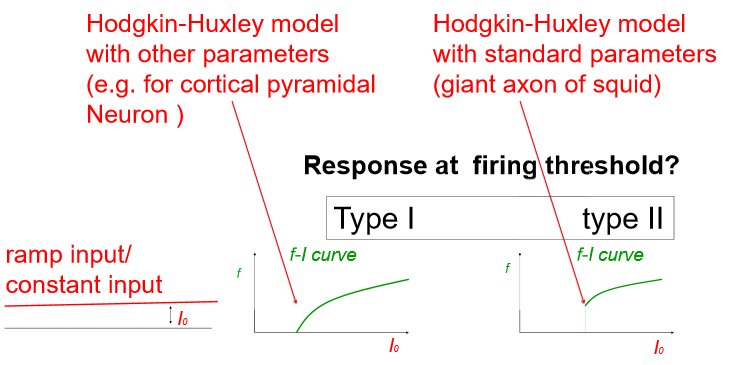

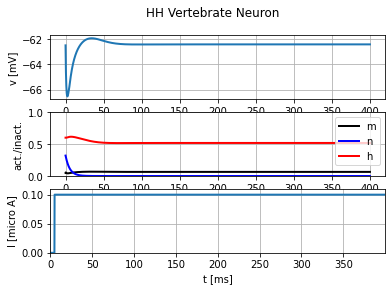

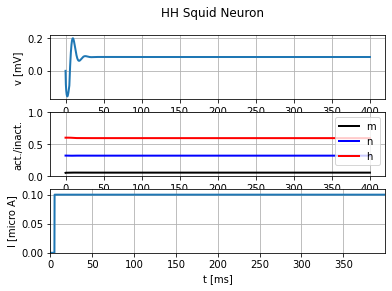

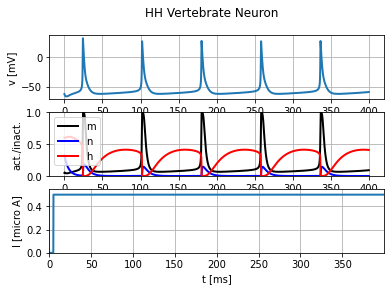

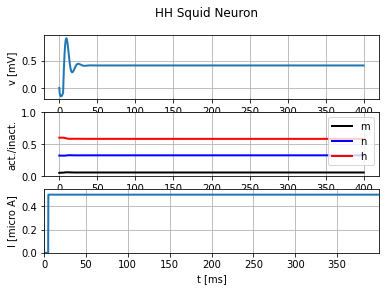

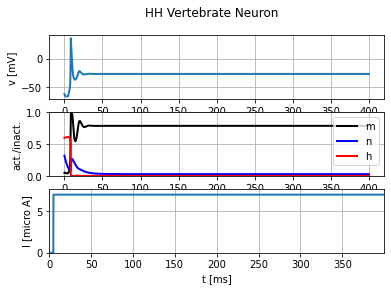

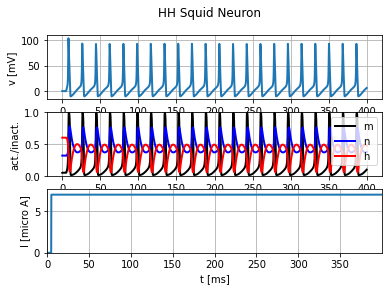

In [6]:
I_min = [0.1,0.5,7]

for idx in I_min:
  current = input_factory.get_step_current(5, 400, b2.ms, idx *b2.uA)
  state_monitor = vertebrate_simulate_HH_neuron(current, 400 * b2.ms)
  HH.plot_data(state_monitor, title="HH Vertebrate Neuron")

  state_monitor = my_simulate_HH_neuron(current, 400 * b2.ms,1,1)
  HH.plot_data(state_monitor, title="HH Squid Neuron")

### Question 3

Relative refractory period. 
The HH neuron exhibits relative refratoriness, which means that it is more difficult to fire a neuron again right after it fired. To see this we will generate two steps of current. The first will generate a spike. We will study the effect of the second pulse.

The function below generates the two steps of current (modified from the `input_factory` module). Please run it so that you have it defined 

In [7]:
def get_two_step_current(t1_start, t1_end, t2_start, t2_end, 
                     unit_time, amplitude1, amplitude2, append_zero=True):

    """Creates two steps current. 

    Args:
        t1_start (int): start of the first step
        t1_end (int): end of the first step
        t2_start (int): start of the second step
        t2_end (int): end of the step
        unit_time (Brian2 unit): unit of t_start and t_end. e.g. 0.1*brian2.ms
        amplitude1 (Quantity): amplitude of the first step. e.g. 3.5*brian2.uamp
        amplitude1 (Quantity): amplitude of the second step. e.g. 3.5*brian2.uamp


        append_zero (bool, optional): if true, 0Amp is appended at t_end+1.
        Without that trailing 0, Brian reads out the last value in the array (=amplitude) for all indices > t_end.

    Returns:
        TimedArray: Brian2.TimedArray
    """

    assert isinstance(t1_start, int), "t_start_ms must be of type int"
    assert isinstance(t1_end, int), "t_end must be of type int"
    assert isinstance(t2_start, int), "t_start_ms must be of type int"
    assert isinstance(t2_end, int), "t_end must be of type int"
    assert b2.units.fundamentalunits.have_same_dimensions(amplitude1, b2.amp), \
        "amplitude must have the dimension of current e.g. brian2.uamp"
    assert b2.units.fundamentalunits.have_same_dimensions(amplitude2, b2.amp), \
        "amplitude must have the dimension of current e.g. brian2.uamp"
    tmp_size = 1 + t2_end  # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((tmp_size, 1)) * b2.amp
    tmp[t1_start: t1_end + 1, 0] = amplitude1
    tmp[t2_start: t2_end + 1, 0] = amplitude2
    curr = b2.TimedArray(tmp, dt=1. * unit_time)
    return curr

The code below is a starting point. You will see that the second pulse, while identical to the first, does not elicit a spike.

Here pulses have a width of 1 ms (notice that the current vector is in 0.1 ms units), and 5 uA amplitude. They occur at a time interval of 60 ms. 

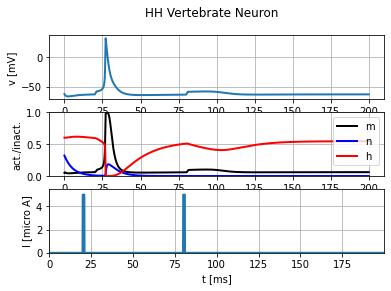

In [8]:
I1 = 5
I2 = 5
current = get_two_step_current(200, 210, 800, 810, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron")

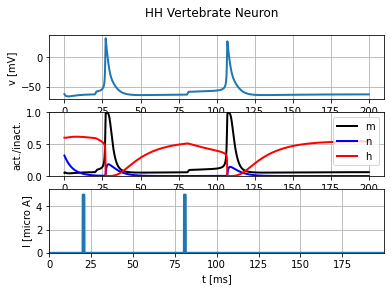

In [9]:
I1 = 5
I2 = 5
current = get_two_step_current(200, 210, 805, 815, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron")

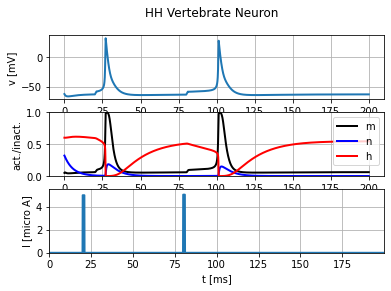

In [10]:
I1 = 5
I2 = 5.05
current = get_two_step_current(200, 210, 800, 810, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron")

#### Questions 
1. Why is it the case that the second pulse doesn't cause a spike in the simulation above?
2. Repeat the simulation and find out how long do you have to wait for the second pulse to be effective
3. now find out what is the threshold for firing for the first pulse and the second pulse (after 60 ms from the first) 

### Answer Question 3

1. The second pulse doesn't cause a spike because the h gate had not returned to its initial state yet, thus making it harder for the spike to be elicited.

2. Waiting an additional .5 milliseconds would have elicited the spike for the same parameters; therefore, waiting 60.5 milliseconds between spikes with amplitude $ 5μA$ 

3. The current threshold for firing a second time, 60ms after the first time, is $5.05μA$

### Question 4 
See [Question 6.3](http://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html#exercise-rebound-spike)
Release from hyperpolarization may cause a neuron to fire 
This fairly counterintuitive phenomenon can be shown with a simple simulation 

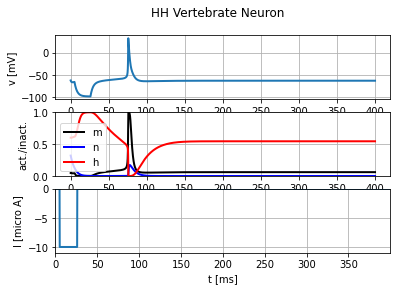

In [11]:
I_min = -10
current = input_factory.get_step_current(5, 25, b2.ms, I_min *b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 400 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron")

#### Questions 
1. Which variable is responsible for the spike?
2. With these settings, the spike takes place with some delay. Why? which variable is responsible?

## Answer Question 4

- due to the negative input pulse, the membrane is hyperpolarized. For a hyperpolarized membrane, we see that h opens almost completely, and m is closed completely. 
- A major difference between the h and m gate is their respective time-scales, which significantly differ. h has a very long time-scale, whereas m has a very short time-scale. 

1. Thus, during the hyperpolarizing pulse, h is almost completely open, and n & m completely closed. After the pulse, the membrane potential depolarizes towards the resting potential. Once m opens slightly, a huge influx of ions occurs due to its very small time-scale, causing the spike.

2. h has a long time-scale, which causes the delay. m has to wait for h to be able to facilitate the spike.

## q4 continuation

An hyperpolarization can also affect the effects of a following depolarizing pulse

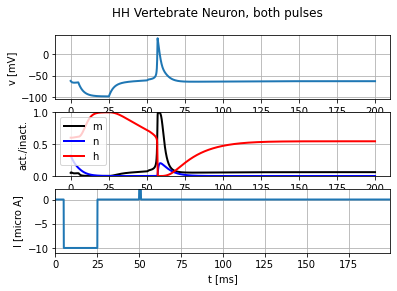

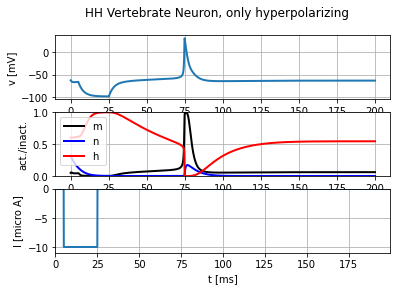

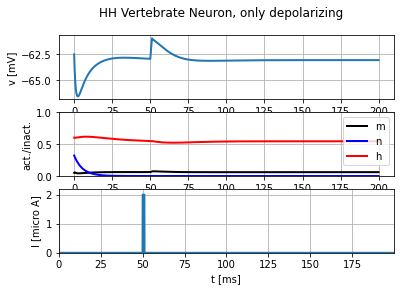

In [26]:
I1 = -10
I2 = 2
current = get_two_step_current(50, 250, 500, 510, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron, both pulses")

I1 = -10
I2 = 0
current = get_two_step_current(50, 250, 500, 510, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron, only hyperpolarizing")

I1 = 0
I2 = 2
current = get_two_step_current(50, 250, 500, 510, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron, only depolarizing")

#### Questions

3. What is the effect of the second pulse ? How does it compare with the simulation with only the negative pulse? (set I2 to zero to compare)

4. How does this simulation compare with giving a depolarizing pulse without the negative pulse before? (set I1 to zero to compare)

#### Answers Q4
3) The second pulse advances the spike, making it occur earlier

4) Only giving a depolarizing pulse without the negative pulse beforehand doesn't give any spiking behaviour

#### Question 4.5
Now decrease the amplitude of the negative pulse so that, in the absence of the positive pulse you get no spike. Add the positive pulse, what happens?



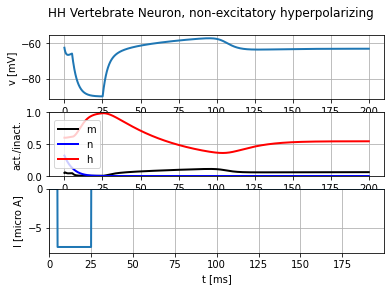

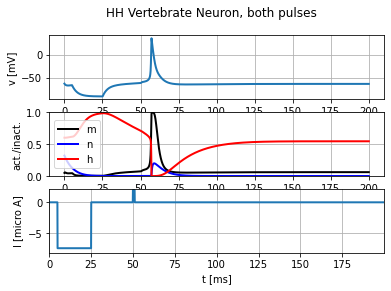

In [30]:
I1 = -7.5
I2 = 0
current = get_two_step_current(50, 250, 500, 510, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron, non-excitatory hyperpolarizing")

I1 = -7.5
I2 = 2
current = get_two_step_current(50, 250, 500, 510, 0.1 * b2.ms, I1 *b2.uA, I2 * b2.uA)
state_monitor = vertebrate_simulate_HH_neuron(current, 200 * b2.ms)
HH.plot_data(state_monitor, title="HH Vertebrate Neuron, both pulses")

#### Answer Question 4.5

Even without having a spike from the hyperpolarizing pulse, adding the depolarizing pulse does induce a spike!